## Transfer learning

2018 showed us that language modelling is a good task to train powerfull text representations. There are two different approaches how to use this representations: **feature extraction** and **fine-tuning**.

  * One great example of feature extraction is ELMo ([allennlp tutorial](https://github.com/allenai/allennlp/blob/master/tutorials/how_to/elmo.md), [tf_hub example](https://tfhub.dev/google/elmo/2), [deeppavlov documentation](http://docs.deeppavlov.ai/en/master/apiref/models/embedders.html?highlight=elmo#deeppavlov.models.embedders.elmo_embedder.ELMoEmbedder))
  * One great example of fine-tuning is ULMfit - ([fastai lesson](https://course.fast.ai/videos/?lesson=4), [example notebook](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb))

What should you do?

  * Apply ELMo to make named entity recognition system. You can use [CONLL 2003 dataset (en)](http://files.deeppavlov.ai/deeppavlov_data/conll2003_v2.tar.gz) or [Persons1000 dataset (ru)](http://labinform.ru/pub/named_entities/descr_ne.htm) or any other dataset.
  * Apply ULMfit to make text classificator (any dataset, except IMDB)
  * Apply ELMo to make text classificator (on the same dataset)
  * Play with various models and hyperparameters
  * Compare results


**Results of this task:**
  * NER model
  * Two classification models
  * for each model:
    * metrics on the test set (quantitative evaluation)
    * succesfull and _unsucsessfull_ examples (qualitative evaluation)
    * plots showing that the model is training


**Additional points:**
  * Early stopping

In [0]:
!pip install allennlp # for getting elmo embeddings

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import csv
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
import torch.autograd as autograd
import torch.utils.data as utils
import fastai
from fastai import *
from fastai.text import * 
from functools import partial
import io
import os
import nltk
from nltk.corpus import stopwords 
from sklearn.model_selection import train_test_split
import allennlp
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# ELMO FOR TEXT CLASSIFICSTION

Get toxic [dataset](https://www.kaggle.com/ra2041/toxic-dataset) + preprocess

In [0]:
data = pd.read_csv("gdrive/My Drive/Colab Notebooks/data/toxic.csv", encoding="latin1")

In [79]:
data.columns.values

array(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], dtype=object)

In [0]:
data = data.drop(data.columns.values[3:], axis=1)
data = data.drop(['id'],axis = 1)
data = data.loc[:5000]

In [0]:
data['comment_text'] = data['comment_text'].str.replace("[^a-zA-Z]", " ")# delete all special symbols, numbers, punctuation

In [0]:
max_len = 50
def make_padded(x):
    result = []
    for i in range(max_len):
        try:
            result.append(x[i])
        except:
            result.append("__PAD__")
    return result

Make paddings for all texts

In [83]:
data['paddings'] = ''
for i in range(len(data)):
  if i % 200 == 0:
    print(i)
  data['paddings'][i] = make_padded(data['comment_text'][i].split())

0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000


## Get embeddings from allennlp

In [118]:
from allennlp.modules.elmo import Elmo, batch_to_ids

options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"

# Compute two different representation for each token.
# Each representation is a linear weighted combination for the
# 3 layers in ELMo (i.e., charcnn, the outputs of the two BiLSTM))
elmo = Elmo(options_file, weight_file, 1, dropout=0)

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [0]:
def embed(batch):
  character_ids = batch_to_ids(batch)
  return elmo(character_ids)

In [0]:
class Batch:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.current = 0
        
    def make_batch(self, batch_size):
        if self.current + batch_size >= len(self.X):
            self.current = 0
        
        sample = embed(self.X[self.current:self.current+batch_size])['elmo_representations'][0].cuda()# batch * 50 * 1024
        pred = torch.tensor((self.y[self.current:self.current+batch_size]).values).cuda()
        self.current = self.current + batch_size
        return sample, pred

In [0]:
batch_size = 64
lr = 0.01
emb_size = 1024
hidden_size = 256
output_size = 2
n_layers = 2
n_batchs = 100
print_every = 1

In [0]:
class Net(nn.Module):
    def __init__(self, emb_size, hidden_size, output_size, n_layers=1):
        super(Net, self).__init__()
        
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(self.emb_size, self.hidden_size, self.n_layers, dropout = 0.2)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)
        self.soft = nn.Softmax(dim=1)
        
    def forward(self, x, hidden):
        output, (final_hidden_state, final_cell_state) = self.lstm(x, hidden)
        final_output = self.decoder(output[-1]) # final_hidden_state.size() = (1, batch_size, hidden_size) & final_output.size() = (batch_size, output_size)
        final_output = self.soft(final_output)
        return final_output
      
    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, device = device).cuda(),\
            torch.zeros(self.n_layers, batch_size, self.hidden_size, device = device).cuda()
    
    def predict(x, hidden):
        batch_size = x.size(0)
        out, hidden = self.lstm(x.view(1, batch_size, -1), hidden)
        out = self.decoder(out.view(batch_size, -1))
        return out, hidden

In [0]:
model = Net(emb_size, hidden_size, output_size, n_layers).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
loss = torch.tensor(0)
b = Batch(data['paddings'], data['toxic'])

In [0]:
def timeSince(since):
    now = time.clock()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
def train(inp, target):
    model.zero_grad()
    loss = 0
    inp = inp.permute(1, 0, 2)#words in sequence x batch_size x embbeding
    hidden = model.init_hidden(inp.shape[1])
    model.train()
    
    out = model(inp, hidden)
    
    loss = criterion(out, target)
    loss.backward()
    optimizer.step()
    
    return loss

In [0]:
losses = []

In [401]:
start_time = time.clock()
for bat in range(1, n_batchs + 1):
    loss = train(*b.make_batch(batch_size))
    losses.append(loss)
    if bat % print_every == 0:
        print('bat {},   \tloss {}'.format(bat, losses[-1]))
        print('time passed %s:' %(timeSince(start_time)))
        

bat 1,   	loss 0.6950652599334717
time passed 0m 18s:
bat 2,   	loss 0.37659063935279846
time passed 0m 35s:
bat 3,   	loss 0.3914007842540741
time passed 0m 52s:
bat 4,   	loss 0.4070131480693817
time passed 1m 9s:
bat 5,   	loss 0.43826183676719666
time passed 1m 26s:
bat 6,   	loss 0.39138689637184143
time passed 1m 45s:
bat 7,   	loss 0.42263686656951904
time passed 2m 2s:
bat 8,   	loss 0.37576189637184143
time passed 2m 19s:
bat 9,   	loss 0.3757617175579071
time passed 2m 36s:
bat 10,   	loss 0.4695117473602295
time passed 2m 54s:
bat 11,   	loss 0.4538867771625519
time passed 3m 12s:
bat 12,   	loss 0.4538867175579071
time passed 3m 31s:
bat 13,   	loss 0.4226367473602295
time passed 3m 49s:
bat 14,   	loss 0.4070117175579071
time passed 4m 7s:
bat 15,   	loss 0.40701165795326233
time passed 4m 26s:
bat 16,   	loss 0.4538867473602295
time passed 4m 45s:
bat 17,   	loss 0.3757616877555847
time passed 5m 4s:
bat 18,   	loss 0.3913867175579071
time passed 5m 22s:
bat 19,   	loss 0

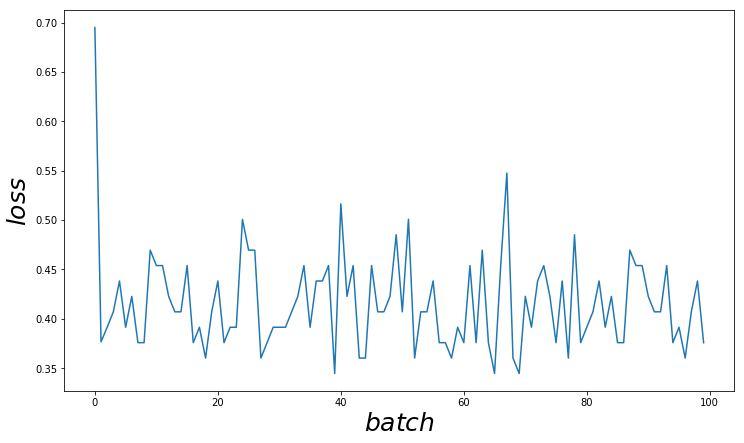

In [402]:
plt.figure(figsize=(12,7))
plt.plot(range(len(losses)), losses)
plt.xlabel("$batch$", fontsize=25)
plt.ylabel("$loss$", fontsize=25)
plt.show()

## Evaluate model

In [0]:
def predict(inp, target):
  inp = inp.permute(1, 0, 2)#words in sequence x batch_size x embbeding
  hidden = model.init_hidden(inp.shape[1])
  model.eval()
  with torch.no_grad():
    out = model(inp, hidden)
    pred = []
    for i in range(inp.shape[1]):
      if out[i][0] > out[i][1]:
        pred.append(0)
      else: 
        pred.append(1)
    print(target.cpu().detach().numpy().sum())
    print(accuracy_score(target.cpu().detach().numpy(),pred))
    print(f1_score(target.cpu().detach().numpy(),pred, average='macro'))

In [415]:
predict(*b.make_batch(100))

8
0.92
0.4791666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


in train data there was too many untoxic texts((